<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy

from bs4 import BeautifulSoup

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [3]:
from bs4 import BeautifulSoup
import requests

##### reading in the CSV #####
df = pd.read_csv('./data/job_listings.csv')
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [9]:
##### Testing BeautifulSoup on one description #####
soup = BeautifulSoup(df['description'][0], 'html.parser')
soup

b"<div><div>Job Requirements:</div><ul><li><p>\nConceptual understanding in Machine Learning models like Nai\xc2\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them</p>\n</li><li><p>Intermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)</p>\n</li><li><p>Exposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R</p>\n</li><li><p>Ability to communicate Model findings to both Technical and Non-Technical stake holders</p>\n</li><li><p>Hands on experience in SQL/Hive or similar programming language</p>\n</li><li><p>Must show past work via GitHub, Kaggle or any other published article</p>\n</li><li><p>Master's degree in Statistics/Mathematics/Computer Science or any other quant specific field.</p></li></ul><div><div><div><div><div><div>\nApply 

In [10]:
##### extracting text #####
soup.get_text()

'b"Job Requirements:\\nConceptual understanding in Machine Learning models like Nai\\xc2\\xa8ve Bayes, K-Means, SVM, Apriori, Linear/ Logistic Regression, Neural, Random Forests, Decision Trees, K-NN along with hands-on experience in at least 2 of them\\nIntermediate to expert level coding skills in Python/R. (Ability to write functions, clean and efficient data manipulation are mandatory for this role)\\nExposure to packages like NumPy, SciPy, Pandas, Matplotlib etc in Python or GGPlot2, dplyr, tidyR in R\\nAbility to communicate Model findings to both Technical and Non-Technical stake holders\\nHands on experience in SQL/Hive or similar programming language\\nMust show past work via GitHub, Kaggle or any other published article\\nMaster\'s degree in Statistics/Mathematics/Computer Science or any other quant specific field.\\nApply Now"'

In [14]:
##### Function to clean #####

def cleaner(docs):
    """ Pass a column of descriptions to get cleaned """
    cleaned = []
    for doc in docs:
        soup = BeautifulSoup(doc, 'html.parser')
        soup = soup.get_text()
        cleaned.append(soup)
    
    return cleaned


##### Using function to clean column #####
df['description_cleaned'] = cleaner(df['description'])
df      

,Unnamed: 0,description,title,description_cleaned
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...
...,...,...,...,...
421,421,"b""<b>About Us:</b><br/>\nWant to be part of a ...",Senior Data Science Engineer,"b""About Us:\nWant to be part of a fantastic an..."
422,422,"b'<div class=""jobsearch-JobMetadataHeader icl-...",2019 PhD Data Scientist Internship - Forecasti...,"b'InternshipAt Uber, we ignite opportunity by ..."
423,423,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist - Insurance,"b'$200,000 - $350,000 a yearA million people a..."
424,424,"b""<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\...",Senior Data Scientist,"b""SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nAB..."


## 2) Use Spacy to tokenize the listings 

In [18]:
nlp = spacy.load("en_core_web_lg")

In [23]:
doc = nlp(df['description_cleaned'][0])
type(doc)

spacy.tokens.doc.Doc

In [24]:
"""
Get the token lemmatization for each token in doc so long as
it is not a stop and word and is not a punctuation word?
"""
print([token.lemma_ for token in doc if (token.is_stop != True) and (token.is_punct != True)])

['b"Job', 'requirements:\\nconceptual', 'understanding', 'Machine', 'Learning', 'model', 'like', 'nai\\xc2\\xa8ve', 'Bayes', 'K', 'Means', 'SVM', 'Apriori', 'Linear/', 'Logistic', 'Regression', 'neural', 'Random', 'Forests', 'decision', 'Trees', 'K', 'NN', 'hand', 'experience', '2', 'them\\nintermediate', 'expert', 'level', 'coding', 'skill', 'Python', 'R.', 'ability', 'write', 'function', 'clean', 'efficient', 'datum', 'manipulation', 'mandatory', 'role)\\nexposure', 'package', 'like', 'NumPy', 'SciPy', 'Pandas', 'Matplotlib', 'etc', 'Python', 'GGPlot2', 'dplyr', 'tidyR', 'R\\nAbility', 'communicate', 'Model', 'finding', 'Technical', 'Non', 'technical', 'stake', 'holders\\nhand', 'experience', 'SQL', 'Hive', 'similar', 'programming', 'language\\nmust', 'past', 'work', 'GitHub', 'Kaggle', 'publish', 'article\\nmaster', 'degree', 'Statistics', 'Mathematics', 'Computer', 'Science', 'quant', 'specific', 'field.\\napply']


In [29]:
##### Building a function to get each listings tokens #####

def get_tokens(listings):
    """ Takes a pandas column and returns an array of tokens """
    tokens_list = []
    for listing in listings:
        listing = nlp(listing)
        one_listing = []
        for token in listing:
            if ((token.is_stop != True) and (token.is_punct != True)):
                one_listing.append(token.lemma_)
        tokens_list.append(one_listing)
        
    return tokens_list
        
# Using function to create a tokens list column
df['tokens'] = get_tokens(df['description_cleaned'])
df

,Unnamed: 0,description,title,description_cleaned,tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b""Job, requirements:\nconceptual, understandi..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b'Job, description\n\na, Data, scientist, 1, ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b'As, Data, scientist, work, consult, busines..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b'$4,969, $, 6,756, monthcontractunder, gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."
...,...,...,...,...,...
421,421,"b""<b>About Us:</b><br/>\nWant to be part of a ...",Senior Data Science Engineer,"b""About Us:\nWant to be part of a fantastic an...","[b""About, Us:\nWant, fantastic, fun, startup, ..."
422,422,"b'<div class=""jobsearch-JobMetadataHeader icl-...",2019 PhD Data Scientist Internship - Forecasti...,"b'InternshipAt Uber, we ignite opportunity by ...","[b'InternshipAt, Uber, ignite, opportunity, se..."
423,423,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist - Insurance,"b'$200,000 - $350,000 a yearA million people a...","[b'$200,000, $, 350,000, yearA, million, peopl..."
424,424,"b""<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\...",Senior Data Scientist,"b""SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nAB...","[b""SENIOR, DATA, SCIENTIST\nJOB, description\n..."


## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [34]:
df

,Unnamed: 0,description,title,description_cleaned,tokens
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""Job Requirements:\nConceptual understanding ...","[b""Job, requirements:\nconceptual, understandi..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'Job Description\n\nAs a Data Scientist 1, yo...","[b'Job, description\n\na, Data, scientist, 1, ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'As a Data Scientist you will be working on c...,"[b'As, Data, scientist, work, consult, busines..."
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthContractUnder the gen...","[b'$4,969, $, 6,756, monthcontractunder, gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'Location: USA \xe2\x80\x93 multiple location...,"[b'Location, USA, \xe2\x80\x93, multiple, loca..."
...,...,...,...,...,...
421,421,"b""<b>About Us:</b><br/>\nWant to be part of a ...",Senior Data Science Engineer,"b""About Us:\nWant to be part of a fantastic an...","[b""About, Us:\nWant, fantastic, fun, startup, ..."
422,422,"b'<div class=""jobsearch-JobMetadataHeader icl-...",2019 PhD Data Scientist Internship - Forecasti...,"b'InternshipAt Uber, we ignite opportunity by ...","[b'InternshipAt, Uber, ignite, opportunity, se..."
423,423,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist - Insurance,"b'$200,000 - $350,000 a yearA million people a...","[b'$200,000, $, 350,000, yearA, million, peopl..."
424,424,"b""<p></p><div><p>SENIOR DATA SCIENTIST</p><p>\...",Senior Data Scientist,"b""SENIOR DATA SCIENTIST\nJOB DESCRIPTION\n\nAB...","[b""SENIOR, DATA, SCIENTIST\nJOB, description\n..."


In [67]:
from sklearn.feature_extraction.text import CountVectorizer

# bag_of_words = []
# for tokens in df['tokens']:
#     for token in tokens:
#         bag_of_words.append(token)

# create the transformer
vect = CountVectorizer(stop_words='english', max_features=1000)

# build vocab
vect.fit(df['description_cleaned'])

# transform text
dtm = vect.transform(df['description_cleaned'])


In [68]:
type(dtm.todense())

numpy.matrix

In [69]:
print(dtm)

  (0, 6)	1
  (0, 129)	1
  (0, 140)	1
  (0, 154)	1
  (0, 170)	1
  (0, 207)	1
  (0, 212)	1
  (0, 218)	1
  (0, 278)	1
  (0, 319)	2
  (0, 326)	1
  (0, 345)	1
  (0, 348)	1
  (0, 367)	1
  (0, 392)	1
  (0, 401)	1
  (0, 453)	1
  (0, 460)	1
  (0, 473)	1
  (0, 476)	1
  (0, 483)	2
  (0, 486)	1
  (0, 498)	1
  (0, 517)	1
  (0, 521)	1
  :	:
  (425, 892)	1
  (425, 894)	1
  (425, 898)	1
  (425, 902)	3
  (425, 903)	1
  (425, 904)	1
  (425, 916)	1
  (425, 917)	1
  (425, 920)	1
  (425, 923)	1
  (425, 928)	1
  (425, 932)	1
  (425, 935)	1
  (425, 936)	1
  (425, 944)	2
  (425, 948)	1
  (425, 953)	1
  (425, 968)	6
  (425, 970)	1
  (425, 971)	1
  (425, 978)	5
  (425, 980)	2
  (425, 986)	3
  (425, 995)	5
  (425, 998)	2


In [70]:
dtm.todense()
type(dtm)

scipy.sparse.csr.csr_matrix

In [71]:
# Each row represents a document
dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm

,000,10,100,2019,40,abilities,ability,able,academic,access,...,xa6,xae,xb7,xbb,xc2,xe2,xef,year,years,york
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,...,2,0,0,0,0,8,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0,0,0,0,2,0,2,0,0,0,...,0,0,0,0,0,4,0,2,3,1
422,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
423,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
424,0,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,2,0,0,1,0


In [72]:
totals = dtm.aggregate(['sum'])
totals

,000,10,100,2019,40,abilities,ability,able,academic,access,...,xa6,xae,xb7,xbb,xc2,xe2,xef,year,years,york
sum,52,35,39,43,28,41,318,122,37,71,...,28,49,28,33,114,1417,75,73,443,34


In [73]:
# Top words
totals.sort_values(by='sum', ascending=False, axis=1)

,data,xe2,x80,experience,business,work,team,science,learning,analytics,...,extraction,peers,nlead,specifically,video,helps,request,uncover,drug,personalization
sum,4394,1417,1404,1238,1198,976,972,956,912,730,...,26,26,26,26,26,26,26,26,26,26


## 4) Visualize the most common word counts

In [93]:
top_words = totals.sort_values(by='sum', ascending=False, axis=1)
words = list(top_words.columns)[:15]
words

['data',
 'xe2',
 'x80',
 'experience',
 'business',
 'work',
 'team',
 'science',
 'learning',
 'analytics',
 'machine',
 'analysis',
 'skills',
 'nexperience',
 'models']

In [94]:
counts = list(top_words.iloc[0].values[:15])
counts

[4394,
 1417,
 1404,
 1238,
 1198,
 976,
 972,
 956,
 912,
 730,
 686,
 675,
 673,
 616,
 614]

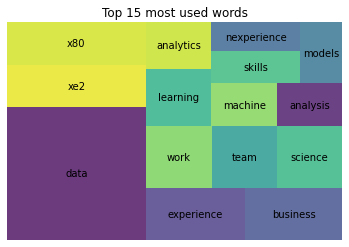

In [98]:
import squarify
import matplotlib.pyplot as plt

squarify.plot(sizes=counts, label=words, alpha=.8)
plt.axis('off')
plt.title("Top 15 most used words")
plt.show()

"""
Like you mentioned in slack... I should make another co
"""

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [103]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Instantiate vectorizer object
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)

# Create a vocabulary and get word counts per document
# Similiar to fit_predict
dtm = tfidf.fit_transform(df['description_cleaned'])

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
dtm

,000,04,10,100,1079302,11,12,125,14,15,...,years,yearthe,yes,yeti,york,young,yrs,zeus,zf,zillow
0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.093431,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.043033,0.0,0.0,0.0,0.038609,0.0,0.0,0.0,0.0,0.0
422,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
423,0.118271,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
424,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.018824,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [104]:
from sklearn.neighbors import NearestNeighbors

# Fit on DTM
nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [105]:
ideal_job = ["""
    Data science big payout million on millions. racks on racks. We don't micromanage!
    Skills needed: Python, matplotlib, pandas, machine learning
"""]

obj = tfidf.transform(ideal_job)
obj

<1x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 13 stored elements in Compressed Sparse Row format>

In [106]:
nn.kneighbors(obj.todense())

(array([[1.29405693, 1.29413966, 1.30069413, 1.30212459, 1.32463284]]),
 array([[382, 424, 168,   0, 144]], dtype=int64))

In [109]:
# Most similar
df['description_cleaned'][382]

'b"DATA SCIENTIST\\nJOB DESCRIPTION\\n\\nABOUT US\\n\\nAmplion synthesizes the world\\xe2\\x80\\x99s biomedical knowledge to accelerate Precision Medicine and enable confident strategic decisioning in drug and diagnostic development. The company\'s SaaS platform leverages machine learning to provide actionable intelligence across millions of disparate data sources, delivering the leading solution for pre-clinical and clinical evidence in the Life Sciences industry.\\n\\nAll of us at Amplion are extremely passionate about enabling the life science industry to deliver on the promise of precision medicine. No disruption of a major industry happens with an individual. It takes a great team, aligned around something meaningful and big. If you share in our passion and want to work for a growing company with the opportunity for professional growth with purpose, we\\xe2\\x80\\x99d love to meet you.\\n\\nTHE ROLE\\n\\nWe are looking for a Data Scientist who will support our effort to accelerate

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 